In [ ]:
%cd /content/drive/MyDrive/

/content/drive/MyDrive


In [ ]:
file_name = "./BUC/master.xlsx"

In [ ]:
import pandas as pd
!pip install -U pandasql
from pandasql import sqldf 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for pandasql: filename=pandasql-0.7.3-py3-none-any.whl size=26784 sha256=4325fe803bd10bea0c824cf91da082bb89b23aef9cfe998c82f16c510e62440a
  Stored in directory: /root/.cache/pip/wheels/5c/4b/ec/41f4e116c8053c3654e2c2a47c62b4fca34cc67ef7b55deb7f
Successfully built pandasql


In [ ]:
import numpy as np
data = pd.read_excel(file_name,dtype=np.str)
data = pd.DataFrame(data)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


In [ ]:

N,M = data.shape
cols = data.columns

In [ ]:
data

,country,year,sex,age,suicides_no,population,suicides/100k pop,country-year,HDI for year,gdp_for_year ($),gdp_per_capita ($),generation
0,Albania,1987.0,male,15-24 years,21.0,312900.0,6.71,Albania1987,NaN,2156624900.0,796.0,Generation X
1,Albania,1987.0,male,35-54 years,16.0,308000.0,5.19,Albania1987,NaN,2156624900.0,796.0,Silent
2,Albania,1987.0,female,15-24 years,14.0,289700.0,4.83,Albania1987,NaN,2156624900.0,796.0,Generation X
3,Albania,1987.0,male,75+ years,1.0,21800.0,4.59,Albania1987,NaN,2156624900.0,796.0,G.I. Generation
4,Albania,1987.0,male,25-34 years,9.0,274300.0,3.28,Albania1987,NaN,2156624900.0,796.0,Boomers
...,...,...,...,...,...,...,...,...,...,...,...,...
27815,Uzbekistan,2014.0,female,35-54 years,107.0,3620833.0,2.96,Uzbekistan2014,0.675,63067077179.0,2309.0,Generation X
27816,Uzbekistan,2014.0,female,75+ years,9.0,348465.0,2.58,Uzbekistan2014,0.675,63067077179.0,2309.0,Silent
27817,Uzbekistan,2014.0,male,5-14 years,60.0,2762158.0,2.17,Uzbekistan2014,0.675,63067077179.0,2309.0,Generation Z
27818,Uzbekistan,2014.0,female,5-14 years,44.0,2631600.0,1.67,Uzbekistan2014,0.675,63067077179.0,2309.0,Generation Z


In [ ]:

print("No of records : ",N)
print("No of columns : ",M)

No of records :  300
No of columns :  3


In [ ]:
data

,country,year,sex
0,Albania,1987.0,male
1,Albania,1987.0,male
2,Albania,1987.0,female
3,Albania,1987.0,male
4,Albania,1987.0,male
...,...,...,...
295,Antigua and Barbuda,1987.0,male
296,Antigua and Barbuda,1987.0,male
297,Antigua and Barbuda,1987.0,male
298,Antigua and Barbuda,1987.0,male


In [ ]:
class BUC_fit:
  def __init__(self,min_support,cur_dir):
    self.level = 0
    self.min_support = min_support
    self.data_cube_counter = 0
    self.comb = ""
    self.comb_ele = ""
    self.data_cube_files_dict = {}
    self.cur_dir = cur_dir
    self.total_count=0

  def partition(self,R,d):
    return sqldf(f'select \"{cols[d]}\", COUNT(*) as count from R group by \"{cols[d]}\" order by COUNT(*)',locals())


  def convert_to_columns(self,comb):
    l = []
    k = 0
    for i in range(0,len(comb),1):
      if(comb[i]=='~'):
        l.append(comb[k:i])
        k=i+1
    col_string = ""
    for ind in l:
      col_string += cols[int(ind)]
      col_string += '~'
    return col_string

  def is_file_present(self,comb):
    import os
    l = os.listdir(self.cur_dir)
    return comb+".txt" in l

  def create_partitioned_table(self,R,d,M,ele):
    column_string = ""
    for k in range(d,M,1):
      column_string += "\""
      column_string += cols[k]    
      column_string += "\""
      if(k!=(M-1)):
        column_string+=', '
    return sqldf(f'select {column_string} from R where \"{cols[d]}\" = \"{ele}\"',locals())

  def BUC(self,R,dim,comb="",comb_ele=""):
    self.level += 1
    for d in range(dim,M,1):

      partitions = self.partition(R,d)
      cardinality = partitions.shape[0]
      for c in range(cardinality):

        freq = partitions.iloc[c][1]
        ele = partitions.iloc[c][0]

        if(freq < self.min_support):
          continue
        import os
        dirs = os.listdir(self.cur_dir)
        if f"Level-{self.level}" not in dirs:
          os.mkdir(f"{self.cur_dir}/Level-{self.level}")
        with open(f"{self.cur_dir}/Level-{self.level}/{comb}{d}~.txt",'a') as f:
          self.total_count += 1
          f.write(comb_ele+f"{ele}~"+str(freq)+"\n")
          f.close()

        partitioned_table = self.create_partitioned_table(R,d,M,ele)
        self.BUC(partitioned_table,d+1,comb+f"{d}~",comb_ele+f"{ele}~")


    self.level -= 1    
    return self.total_count

In [ ]:
cols

Index(['country', 'year', 'sex'], dtype='object')

In [ ]:
def get_tuple_size(l):
  size = 0
  for c in l:
    if(isinstance(c,str)):
      size += len(c)*8
    if(isinstance(c,float)):
      size += 8
  return size

def write_string(row,f):
  s=""
  for c in row:
    s+=str(c)+'~'
  f.write(s)
  f.write("\n")

def dataPartioner(data,paging_path):
  import os
  
  try:
    os.mkdir(paging_path)
  except:
    pass
  delimeter = '~'
  paths = {}
  for index,row in data.iterrows():
    country = row['country']
    try:
      with open(paths[country],'a') as f:
        write_string(row,f)
        f.close()
    except: 
      paths[country] = paging_path+country
      with open(paging_path+country,'w') as f:
        write_string(row,f)
        f.close()



In [ ]:

#Memory fixed M
def memory_fixed_BUC(page_size,M,min_support):
  i=0
  t = 0
  while i < len(page_size):
    k=i
    size_sum = 0
    while i < len(page_size) :
      if(size_sum + page_size[i][1] > M):
        break
      size_sum += page_size[i][1]
      i+=1


    memory_data = []
    for j in range(k,i,1):
      with open(page_size[j][0],'r') as f:
        memory_data += [ line.split('~')[:-1] for line in f.readlines() ]

    partioned_data = pd.DataFrame(memory_data,columns=cols)
    
    t+= BUC_fit(min_support,'./BUC').BUC(partioned_data,0)
    
    print(f"{i} out of {len(page_size)} processed !")
  return t

In [ ]:

dataPartioner(data,"./BUC/pages/")

In [ ]:

page_size = []
import os
for f_name in os.listdir("./BUC/pages/"):
  page_size.append(["./BUC/pages/"+f_name,os.path.getsize("./BUC/pages/"+f_name)])

page_size.sort(key=lambda a : a[1] )


In [ ]:
page_size

In [ ]:
print(BUC_fit(3,'./BUC_in').BUC(data,0))

155


In [ ]:
print(memory_fixed_BUC(page_size,5900,3))

In [ ]:
# Memory Fixed analysis
min_s = [100,500,1000,2500,5000,10000]
time_s = []

In [ ]:
import time
s1 = time.time()
BUC_fit(min_s[5],'./BUC_in').BUC(data,0)
time_s.append(time.time() - s1)

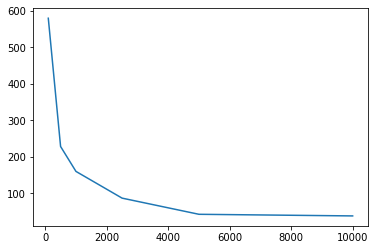

In [ ]:
from matplotlib import pyplot as plt
plt.plot(min_s,time_s)
plt.show()

In [ ]:
page_size 

[['./BUC/pages/Mongolia', 1018],
 ['./BUC/pages/Macau', 1128],
 ['./BUC/pages/Dominica', 1159],
 ['./BUC/pages/Cabo Verde', 1236],
 ['./BUC/pages/Bosnia and Herzegovina', 3140],
 ['./BUC/pages/Oman', 3390],
 ['./BUC/pages/San Marino', 3685],
 ['./BUC/pages/Saint Kitts and Nevis', 4409],
 ['./BUC/pages/Nicaragua', 7554],
 ['./BUC/pages/Turkey', 8611],
 ['./BUC/pages/United Arab Emirates', 9121],
 ['./BUC/pages/Maldives', 11739],
 ['./BUC/pages/Fiji', 11933],
 ['./BUC/pages/Montenegro', 12238],
 ['./BUC/pages/Kiribati', 12511],
 ['./BUC/pages/Sri Lanka', 13992],
 ['./BUC/pages/Aruba', 15514],
 ['./BUC/pages/Qatar', 17030],
 ['./BUC/pages/Cyprus', 17301],
 ['./BUC/pages/Philippines', 19728],
 ['./BUC/pages/Azerbaijan', 19887],
 ['./BUC/pages/Jamaica', 20046],
 ['./BUC/pages/Serbia', 21395],
 ['./BUC/pages/Seychelles', 22067],
 ['./BUC/pages/Bahrain', 24873],
 ['./BUC/pages/Latvia', 24912],
 ['./BUC/pages/Estonia', 25256],
 ['./BUC/pages/Belarus', 25650],
 ['./BUC/pages/Albania', 25900],
 

In [ ]:
memory_size = [1,2,4,0.5,0.1]


In [ ]:
import time
s = time.time()
memory_fixed_BUC(page_size,memory_size[4]*1e6,1000)
time_memory.append(time.time()-s)

15 out of 101 processed !
20 out of 101 processed !
24 out of 101 processed !
27 out of 101 processed !
30 out of 101 processed !
33 out of 101 processed !
36 out of 101 processed !
39 out of 101 processed !
42 out of 101 processed !
45 out of 101 processed !
48 out of 101 processed !
51 out of 101 processed !
54 out of 101 processed !
56 out of 101 processed !
58 out of 101 processed !
60 out of 101 processed !
62 out of 101 processed !
64 out of 101 processed !
66 out of 101 processed !
68 out of 101 processed !
70 out of 101 processed !
72 out of 101 processed !
74 out of 101 processed !
76 out of 101 processed !
78 out of 101 processed !
80 out of 101 processed !
82 out of 101 processed !
84 out of 101 processed !
86 out of 101 processed !
88 out of 101 processed !
90 out of 101 processed !
92 out of 101 processed !
94 out of 101 processed !
96 out of 101 processed !
98 out of 101 processed !
100 out of 101 processed !
101 out of 101 processed !


In [ ]:
memory_size = [0.1,0.5,1,2,4]
time_memory = [27.97177815437317,55.176008224487305,102.53615212440491, 141.9711558818817, 186.30846643447876]

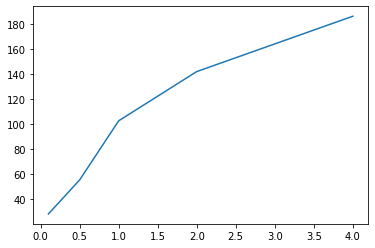

In [ ]:
from matplotlib import pyplot as plt
plt.plot(memory_size,time_memory)
plt.show()